In [54]:
# reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose GPU (this may not be needed on your computer)

In [55]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [56]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [57]:
from tfumap.umap import tfUMAP

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [59]:
dataset = 'fmnist'

In [60]:
from tensorflow.keras.datasets import fashion_mnist

In [61]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [62]:
dims = (28,28,1)
n_components = 2

In [63]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [64]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

In [65]:
input_img = tf.keras.Input(dims)
output_img = decoder(encoder(input_img))
autoencoder = tf.keras.Model(input_img, output_img)

In [66]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [67]:
X_train = X_train.reshape([len(X_train)] + list(dims))
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                #validation_data=(X_valid, X_valid)
                         )

Epoch 1/50
196/196 [==============================] - 6s 28ms/step - loss: 0.3870
Epoch 2/50
196/196 [==============================] - 5s 26ms/step - loss: 0.3325
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 0.3278
Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 0.3252
Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 0.3234
Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 0.3223
Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 0.3211
Epoch 8/50
196/196 [==============================] - 5s 25ms/step - loss: 0.3199
Epoch 9/50
196/196 [==============================] - 5s 26ms/step - loss: 0.3199
Epoch 10/50
196/196 [==============================] - 6s 28ms/step - loss: 0.3186
Epoch 11/50
196/196 [==============================] - 5s 26ms/step - loss: 0.3181
Epoch 12/50
196/196 [==============================] - 5s 28ms/step - loss: 0.3175
Epoch 13/50
1

In [68]:
z = encoder.predict(X_train)

### Plot model output

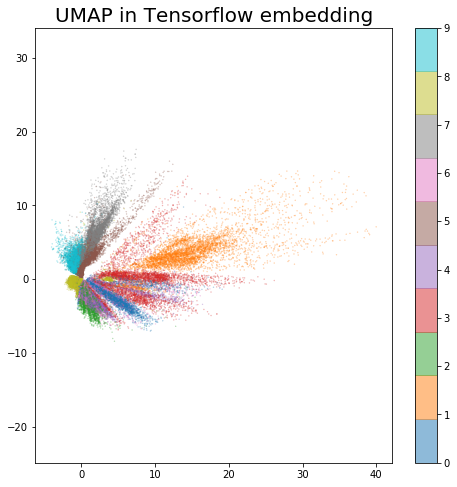

In [69]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [70]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [71]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [72]:
output_dir = MODEL_DIR/'projections'/ dataset / 'ae_only'
ensure_dir(output_dir)

In [73]:
encoder.save(output_dir / 'encoder')

I0821 22:25:21.517111 139670546110272 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/ae_only/encoder/assets


In [74]:
decoder.save(output_dir / 'encoder')

I0821 22:25:23.397414 139670546110272 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/ae_only/encoder/assets


In [75]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [76]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [77]:
X_test.shape

(10000, 784)

In [78]:
z_test = encoder.predict(X_test.reshape((len(X_test), 28,28,1)))

#### silhouette

In [79]:
from tfumap.silhouette import silhouette_score_block

In [80]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.04265441076727449

In [81]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.041124506213625844

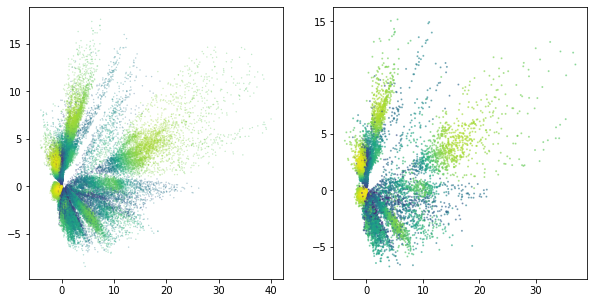

In [82]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.7339

In [85]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.6816

#### Trustworthiness

In [86]:
from sklearn.manifold import trustworthiness

In [87]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [88]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [89]:
tw, tw_test

(0.9802722157726181, 0.9703549539631705)

### Save output metrics

In [90]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [91]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,fmnist,ae_only,2,0.980272,0.042654,"[0.612739370235497, 0.2959285771022149, 0.0730..."


In [92]:
save_loc = DATA_DIR / 'projection_metrics' /  'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [93]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,fmnist,ae_only,2,0.970355,0.041125,"[0.48407666629926466, 0.08569577440531292, 0.4..."


In [94]:
save_loc = DATA_DIR / 'projection_metrics' / 'ae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [95]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['ae_only', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ae_only,2,fmnist,0.6816,0.7339


In [96]:
save_loc = DATA_DIR / 'knn_classifier' / 'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [98]:
X_recon = decoder.predict(encoder.predict(X_test.reshape((len(X_test), 28, 28, 1))))
X_real = X_test.reshape((len(X_test), 28, 28, 1))

In [99]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [100]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [101]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['ae_only', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,ae_only,2,fmnist,0.024383,0.084933,0.03799,0.622332


In [102]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'ae_only' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [104]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [105]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'ae_only', z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,fmnist,ae_only,"[[-0.925987, 2.3255062], [5.139722, -3.379672]...","[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, ...",2


In [106]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ae_only_2_fmnist.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,fmnist,ae_only,2,0.424026,0.312922,0.524127,0.391879,0,5,"KMeans(n_clusters=5, random_state=0)"
1,fmnist,ae_only,2,0.423979,0.312400,0.524397,0.391545,1,5,"KMeans(n_clusters=5, random_state=1)"
2,fmnist,ae_only,2,0.424007,0.313425,0.524923,0.392496,2,5,"KMeans(n_clusters=5, random_state=2)"
3,fmnist,ae_only,2,0.423950,0.313376,0.525827,0.392710,3,5,"KMeans(n_clusters=5, random_state=3)"
4,fmnist,ae_only,2,0.424031,0.313069,0.524372,0.392062,4,5,"KMeans(n_clusters=5, random_state=4)"
5,fmnist,ae_only,2,0.419636,0.382328,0.571400,0.458123,0,6,"KMeans(n_clusters=6, random_state=0)"
6,fmnist,ae_only,2,0.419573,0.388489,0.576653,0.464229,1,6,"KMeans(n_clusters=6, random_state=1)"
7,fmnist,ae_only,2,0.419614,0.391023,0.579682,0.467019,2,6,"KMeans(n_clusters=6, random_state=2)"
8,fmnist,ae_only,2,0.419303,0.385190,0.572268,0.460452,3,6,"KMeans(n_clusters=6, random_state=3)"
9,fmnist,ae_only,2,0.419682,0.390250,0.579023,0.466254,4,6,"KMeans(n_clusters=6, random_state=4)"
